# Study of [EPIC228735255](https://exofop.ipac.caltech.edu/k2/edit_target.php?id=228735255)

### Clearing the events in the lightcurve:

I'll start by downloading and plotting the tpf and lc for the concerned object:

/anaconda3/lib/python3.7/site-packages/lightkurve/search.py:141: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


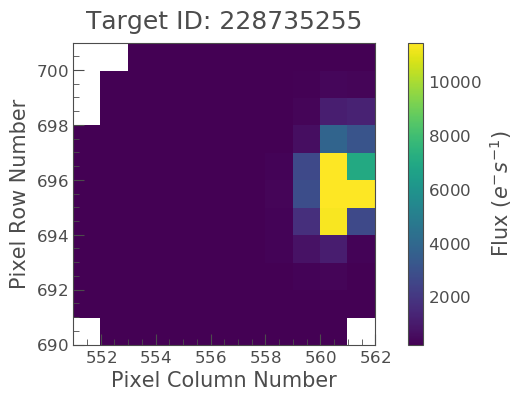

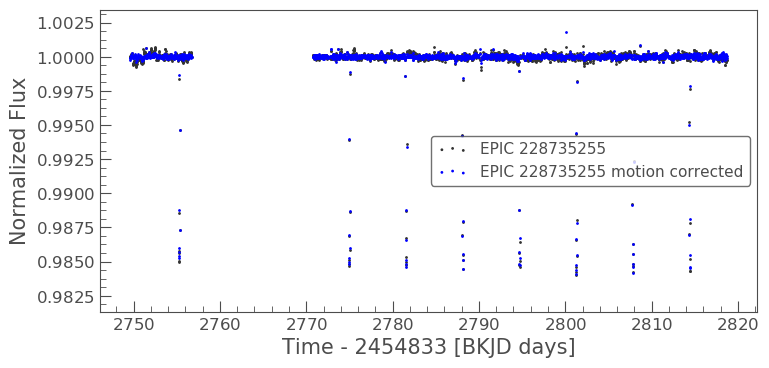

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile
target = '228735255'

tpf = search_targetpixelfile(target).download()
tpf.plot()
lc = search_lightcurvefile(target).download().PDCSAP_FLUX.flatten(window_length=301).remove_nans().remove_outliers(sigma_lower=100,sigma_upper=0.4)
ax = lc.scatter()
corr_lc = lc.to_corrector("sff").correct(windows=40)
corr_lc_f, trend = corr_lc.flatten(window_length=301, return_trend=True)
corr_lc_f.scatter(ax=ax,color='b',label='EPIC 228735255 motion corrected')

We can see a clear period in this lightcurve, now i'll try finding this period using the **box least squares method**:

We can iterate this method to find a more precise result:

And one more iteration:

From this, we get that the period is 6.5690 days.

0.49909464462291453

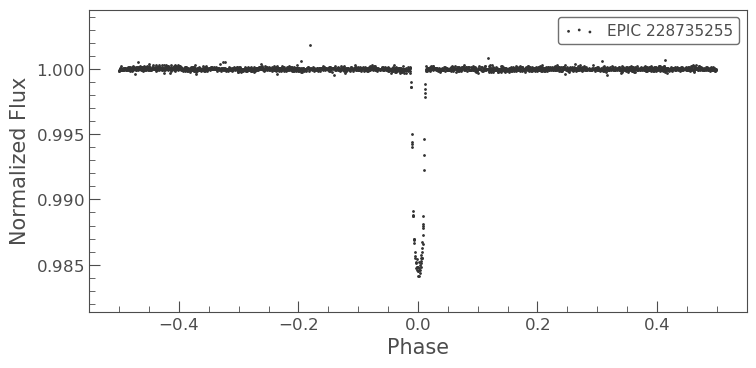

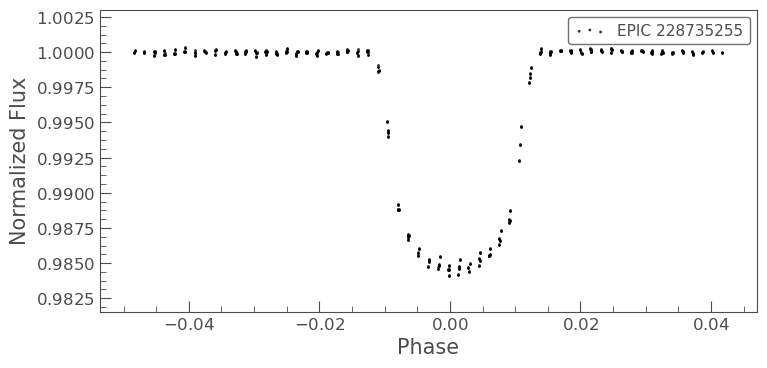

In [183]:
period = 6.5690
lcf = corr_lc_f.fold(period=period,t0=2.87)
lcf.scatter()
lc_transit = lcf[1000:1200]
lc_transit.scatter()
lcf.time_format = 'jd'
plt.scatter(lc_transit.time, lc_transit.flux, s=1, c='k')
plt.savefig('transit.png')
lcf[-1].phase

I will now save this lightcurve to use it directly afterwards:

In [4]:
hdu = lc_transit.to_fits(path='EPIC_228735255_transit.fits', overwrite=True)

### Analysing the object:

Now, knowing that the concerned star's radius is $1.094 R_\odot = 9.8258 R_{Jup}$, and using the formula:
$$ \dfrac{\Delta F}{F} = \dfrac{R_p^2}{R_\odot^2} $$
we can compute the object's radius:

In [5]:
import math

R_star_sr = 1.094 # in sun's radius
R_star = R_star_sr * 695510000 # in meter

T_transit_values = lc_transit.time[lc_transit.flux < 0.9999]
T_transit = T_transit_values[-1] - T_transit_values[0]

R_planet = math.sqrt(1-min(lc_transit.flux))*R_star
R_planet = R_planet / R_star # in jupiter's radius

R_planet, T_transit_values[-1], T_transit_values[0]

(0.1260529072320915, 0.037243263844572994, -0.045277029174144445)

We got $R_p = 1.2432 R_{Jup}$.

Considering $M_p << M_{*}$ and $R_p << R_{*}$, we get the following relations:
$$ a \approx \left( GM_*\left( \dfrac{P^2}{2\pi} \right) \right)^{1/2} $$

$$ i \approx cos^{-1}\left( \left( \left( \dfrac{R_*}{a} \right)^2 - \left( \dfrac{T_{dur} \pi}{P} \right)^2 \right)^{1/2}  \right) $$

$$ b = acos(i) $$

With $T_{dur}$ being the time of the transit.

In [6]:
G = 6.67408 * 10**(-11)
P = period*86400
M = 1.010*1.98847*10**30
a = (G*M*P**2/(2*math.pi)**2) ** (1./3)
i = math.acos(math.sqrt((R_star/a)**2 - (T_transit*math.pi/P)**2)) # in radians
b = a * math.cos(i)

a = a / R_star # astronomical unit
b = b / R_star
i = math.degrees(i)

a, i, b 

(13.540831434063897, 85.76481036654005, 0.9999999999808723)

|      EPIC          |       228735255         |
|:------------------:|:-----------------------:|
|   Planet's period  |       6.5690 days       |
|   Planet's radius  | 1.2377 Jupiter's radius |
| Transit's duration |       0.0232 days       |
|     Inclination    |      88.866°            |
|   Semi-major axis  |        0.2024 AU        |
|   Temperature      |       5654 K            |

Now, we want the limb darkening of our star. For that, we'll use [D. K. Sing's paper](https://arxiv.org/pdf/0912.2274.pdf) on LDCs and the properties of our star: type G5 with a temperature of $5695K$.

The quadratic law:
$$\dfrac{I(\mu)}{I(1)} = 1-u_1(1-\mu) - u_2(1-\mu)^2 $$
With Kepler Stellar Limb-Darkening Coefficients (avereging between 5500K and 5750K), $u_1=0.4218$ and $u_2=0.2442$.

In [7]:
u1 = 0.4218
u2 = 0.2442
µ = math.cos(math.asin(b))

I_b = 1 - u1*(1-µ) - u2*((1-µ)**2)

I_b, µ

(0.3340056296640306, 6.185094894050761e-06)

In [8]:
R_planet = R_planet * 69911000
R_planet = math.sqrt((1-min(lc_transit.flux))/I_b)*R_star
R_planet = R_planet / 69911000

R_planet*11.2

26.58699060406392

## With batman package:

In [438]:
import batman

In [449]:
params = batman.TransitParams()
params.t0 = 0.001                      #time of inferior conjunction
params.per = 0.9986                      #orbital period
params.rp = 0.126                      #planet radius (in units of stellar radii)
params.a = 13.54                     #semi-major axis (in units of stellar radii)
params.inc = 88                   #orbital inclination (in degrees)
params.ecc = 0.                      #eccentricity
params.w = 90.                       #longitude of periastron (in degrees)
params.u = [0.4218, 0.2442]                #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"

In [450]:
t = np.linspace(-0.045, 0.037, 100)    #where the transit is

In [451]:
m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)  #calculates light curve

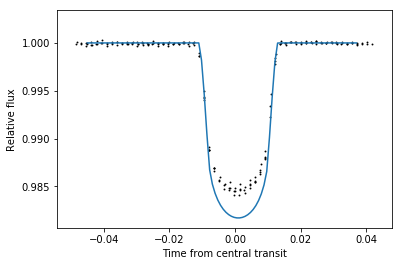

In [452]:
plt.scatter(lc_transit.time, lc_transit.flux, s=.8, c='k')
plt.plot(t, flux)
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
plt.show()

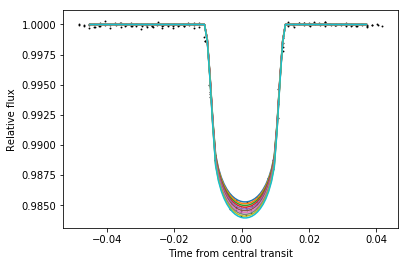

Planet's radius: 0.11744444444444443


In [453]:
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
radii = np.linspace(0.113, 0.118, 10)
possible_radii = []
for r in radii:
        params.rp = r                           #updates planet radius
        new_flux = m.light_curve(params)
        plt.plot(t, new_flux)
        diff = 0
        count = 0
        for f in new_flux:
            diff += abs(lc_transit.flux[count*2]-f)
            count += 1
        possible_radii.append([r,diff])

        
plt.scatter(lc_transit.time, lc_transit.flux, s=.8, c='k')
plt.show()

for i in range(0,len(possible_radii)-1):
    if (possible_radii[i][1]<possible_radii[i+1][1]):
        pos_min = i
    else : pos_min = i + 1

print("Planet's radius: " + str(possible_radii[pos_min][0]))
params.rp = possible_radii[pos_min][0]

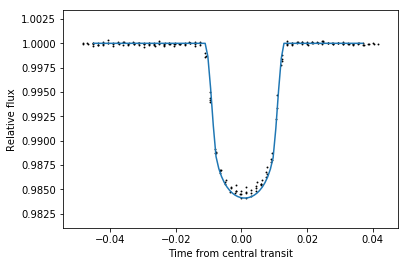

In [454]:
m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)  #calculates light curve

plt.scatter(lc_transit.time, lc_transit.flux, s=.8, c='k')
plt.plot(t, flux)
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
plt.show()

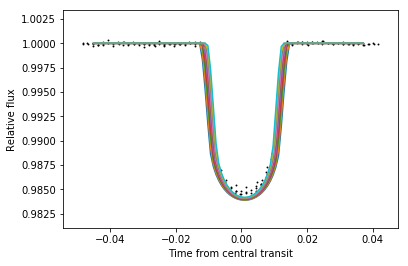

Planet's semi-major axis: 13.777777777777779


In [455]:
plt.scatter(lc_transit.time, lc_transit.flux, s=.8, c='k')
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
axis = np.linspace(12, 14, 10)
possible_axis = []
for a in axis:
        params.a = a                           #updates planet semi-major axis
        new_flux = m.light_curve(params)
        plt.plot(t, new_flux)
        diff = 0
        count = 0
        for f in new_flux:
            diff += abs(lc_transit.flux[count*2]-f)
            count += 1
        possible_axis.append([a,diff])

plt.show()

for i in range(0,len(possible_axis)-1):
    if (possible_axis[i][1]<possible_axis[i+1][1]):
        pos_min = i
    else : pos_min = i + 1

print("Planet's semi-major axis: " + str(possible_axis[pos_min][0]))
params.a = possible_axis[pos_min][0]

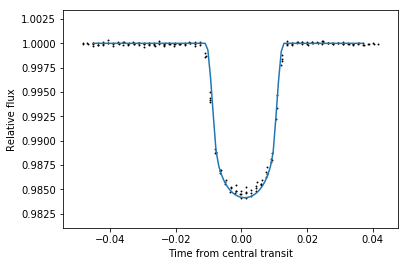

In [456]:
m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)  #calculates light curve

plt.scatter(lc_transit.time, lc_transit.flux, s=.8, c='k')
plt.plot(t, flux)
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
plt.show()

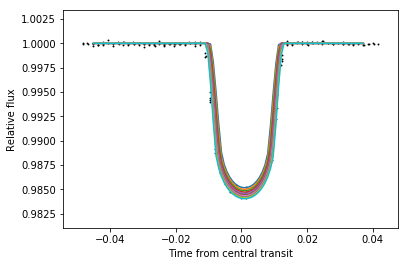

Planet's semi-major axis: 88.0111111111111


In [457]:
plt.scatter(lc_transit.time, lc_transit.flux, s=.8, c='k')
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
incl = np.linspace(87.3, 88.1, 10)
possible_inc = []
for i in incl:
        params.inc = i                           #updates planet semi-major axis
        new_flux = m.light_curve(params)
        plt.plot(t, new_flux)
        diff = 0
        count = 0
        for f in new_flux:
            diff += abs((lc_transit.flux[count*2]+)-f)
            count += 1
        possible_inc.append([i,diff])

plt.show()

for i in range(0,len(possible_inc)-1):
    if (possible_inc[i][1]<possible_inc[i+1][1]):
        pos_min = i
    else : pos_min = i + 1

print("Planet's semi-major axis: " + str(possible_inc[pos_min][0]))
params.i = possible_inc[pos_min][0]

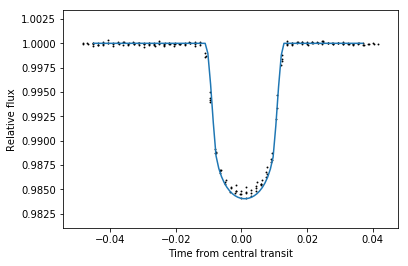

In [458]:
m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)  #calculates light curve

plt.scatter(lc_transit.time, lc_transit.flux, s=.8, c='k')
plt.plot(t, flux)
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
plt.show()